In [1]:
push!(LOAD_PATH, "../src/")

using HDStat, PyPlot, Interact

INFO: Loading help data...


## 1. Testing functions that compute the spectra of Marchenko-Pastur noise model

Note that only the non-zero part of the spectrum is considered regardless of wide/narrow matrices

Options{:ToggleButtons,Int64}([Input{Int64}] 1000,"n",1000,"1000",["1000"=>1000,"2000"=>2000,"5000"=>5000])

Slider{Int64}([Input{Int64}] 2500,"p",2500,100:100:5000)

Slider{Float64}([Input{Float64}] 0.5,"σ",0.5,0.1:0.1:1.0)

Options{:ToggleButtons,Int64}([Input{Int64}] 20,"bins",20,"20",["20"=>20,"50"=>50,"100"=>100,"200"=>200])

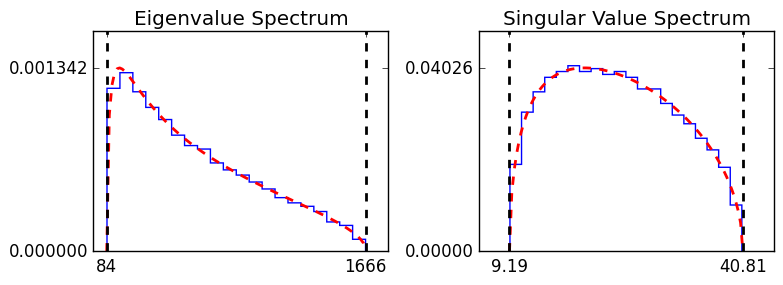

In [7]:
ns = [1000, 2000, 5000]
ps = 100:100:5000

f = figure(figsize=(8, 3))

@manipulate for n in ns, p in ps, σ in 0.1:0.1:1, bins in [20, 50, 100, 200]
    m = MPModel(n, p, σ)
    
    Ss = sv_rand(m)
    Su, Sl = sv_ub(m), sv_lb(m)
    
    Es = ev_rand(m)
    Eu, El = ev_ub(m), ev_lb(m)
    
    svspec = sv_spec(m)
    evspec = ev_spec(m)
    
    withfig(f) do
        x = ev_linsupport(m, 101)
        y = map(evspec, x)
        subplot(121)
        plt.hist(Es, bins, normed=true, histtype="step")
        plt.plot(x, y, "r--", linewidth="2")
        axvline(El, linewidth=2, color="k", linestyle="--")
        axvline(Eu, linewidth=2, color="k", linestyle="--")
        xticks([El, Eu]); yticks([minimum(y), maximum(y)]); ylim([0, maximum(y) * 1.2]); title("Eigenvalue Spectrum")
        
        x = sv_linsupport(m, 101)
        y = map(svspec, x)
        subplot(122)
        plt.hist(Ss, bins, normed=true, histtype="step")
        plt.plot(x, y, "r--", linewidth="2")
        axvline(Sl, linewidth=2, color="k", linestyle="--")
        axvline(Su, linewidth=2, color="k", linestyle="--")
        xticks([Sl, Su]); yticks([minimum(y), maximum(y)]); ylim([0, maximum(y) * 1.2]); title("Singular Value Spectrum")
        
        tight_layout()
    end
end

## 2. Testing functions that deals with the low-rank perturbations to a Marchenko-Pastur noise model

Options{:ToggleButtons,Int64}([Input{Int64}] 500,"n",500,"500",OptionDict({"500","1000"},{"1000"=>1000,"500"=>500}))

Slider{Int64}([Input{Int64}] 500,"p",500,400:100:600)

Slider{Int64}([Input{Int64}] 1,"k",1,1:2)

Slider{Float64}([Input{Float64}] 0.5,"σ",0.5,0.1:0.1:1.0)

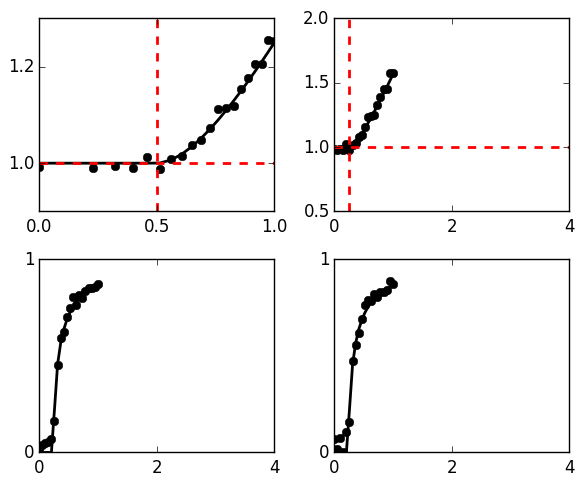

In [16]:
g = figure(figsize=(6, 5))

npt = 20

cca(U, V) = sum(svd(U' * V)[2]) / size(U, 2)

@manipulate for n in [500, 1000], p = 400:100:600, k = 1:2, σ in 0.1:0.1:1
    m = MPModel(n, p, σ)
    
    sthresh = sv_infloor(m)
    sv_out = zeros(npt, k)
    ev_out = zeros(npt, k)
    sv_in = sqrt(linspace(0, sthresh^2 * 4, npt))
    left, right = zeros(npt), zeros(npt)
    for (ksv, sv) in enumerate(sv_in)
        U, V = qr(randn(n, k))[1], qr(randn(p, k))[1]
        X = rand(m) + sv * U * V'
        ev_out[ksv, :] = eigs(X * X'; nev=k)[1]
        sv_out[ksv, :] = sqrt(ev_out[ksv, :])
        Up, _, Vp = svd(X)
        left[ksv], right[ksv] = cca(Up[:, 1:k], U), cca(Vp[:, 1:k], V)
    end
    
    sv_out_theory = map(x -> sv_xfer(m, x), sv_in)
    ev_out_theory = map(x -> ev_xfer(m, x), sv_in.^2)
    tmp = map(x -> svec_overlap(m, x), sv_in)
    left_theory, right_theory = map(x -> x[1], tmp), map(x -> x[2], tmp)
    
    withfig(g) do
        subplot(221)
        PyPlot.locator_params(nbins=3)
        plot(sv_in * sqrt(k / n), sv_out / sqrt(p), "ko")
        plot(sv_in * sqrt(k / n), sv_out_theory / sqrt(p), "k-", linewidth=2)
        axvline(sthresh * sqrt(k / n), color="r", linestyle="--", linewidth=2)
        axhline(sv_xfer(m, sthresh) / sqrt(p), color="r", linestyle="--", linewidth=2)
#         title("Singular Value Phase Transition")
        subplot(222)
        PyPlot.locator_params(nbins=3)
        plot(sv_in.^2 * (k / n), ev_out / p, "ko")
        plot(sv_in.^2 * (k / n), ev_out_theory / p, "k-", linewidth=2)
        axvline(sthresh^2 * (k / n), color="r", linestyle="--", linewidth=2)
        axhline(sv_xfer(m, sthresh)^2 / p, color="r", linestyle="--", linewidth=2)
        xlim([0, 4])
#         title("Eigenvalue Phase Transition")
        subplot(223)
        PyPlot.locator_params(nbins=3)
        plot(sv_in.^2 * (k / n), left, "ko")
        plot(sv_in.^2 * (k / n), left_theory, "k-", linewidth=2)
        yticks([0, 1]); #title("Left Singular Vector Overlap")
        xlim([0, 4])
        subplot(224)
        PyPlot.locator_params(nbins=3)
        plot(sv_in.^2 * (k / n), right, "ko")
        plot(sv_in.^2 * (k / n), right_theory, "k-", linewidth=2)
        yticks([0, 1]); #title("Right Singular Vector Overlap")
        xlim([0, 4])
        tight_layout()
        
        savefig("spike.cov.eps")
    end
end